### ---SINA---

## Imports 

In [1]:
import numpy as np
import json
import re
import math

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate

## Some useful constants

In [2]:
EMB_SIZE = 300
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
TRAIN_BATCH_SIZE = 32
TEST_EVAL_BATCH_SIZE = 32

## Load the data

This data is based on
<a href="http://www.cs.cornell.edu/people/pabo/movie-review-data/">this link</a>
and contains movie reviews sentiment-analysis.

In [3]:
with open('./dataset.json') as f:
    all_dataset = json.load(f)
    
for section in all_dataset.keys():
    l = len(all_dataset[section])
    print(f"{section} lenght is: {l}")

train lenght is: 8000
eval lenght is: 2000
test lenght is: 662


## Download and extract the embeddings

In this project we will use pretrained GloVe model.

using following code you can mount your google drive so you don't need to DL it again.

In [5]:
from google.colab import drive
drive.mount('/content/drive')
# !mkdir '/content/drive/My Drive/GloveEmbeddings'
# !cp /content/glove.6B.zip '/content/drive/My Drive/GloveEmbeddings/'
!unzip '/content/drive/My Drive/GloveEmbeddings/glove.6B.zip' -d "./glove/"

Mounted at /content/drive
Archive:  /content/drive/My Drive/GloveEmbeddings/glove.6B.zip
  inflating: ./glove/glove.6B.50d.txt  
  inflating: ./glove/glove.6B.100d.txt  
  inflating: ./glove/glove.6B.200d.txt  
  inflating: ./glove/glove.6B.300d.txt  


In [5]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-01-02 20:20:29--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-02 20:20:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 39s  

2023-01-02 20:23:09 (5.17 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip ./glove.6B.zip -d "./glove/"

Archive:  ./glove.6B.zip
  inflating: ./glove/glove.6B.50d.txt  
  inflating: ./glove/glove.6B.100d.txt  
  inflating: ./glove/glove.6B.200d.txt  
  inflating: ./glove/glove.6B.300d.txt  


## Create embedding matrix and useful functions

In [4]:
word_list = []
emb_list = []
with open(f'./glove/glove.6B.{EMB_SIZE}d.txt','r') as f:
    for line in f.read().strip().split('\n'):
        values = line.split()
        word = values[0]
        emb = values[1:]
        word_list.append(word)
        emb_list.append(emb)
        
emb_matrix = np.array(emb_list, 'float32')

In [5]:
# We initialize <UNK> token as an average of all embedings
unk_emb = np.mean(emb_matrix, axis=0, keepdims=True)
word_list.append(UNK_TOKEN)
emb_matrix = np.vstack((emb_matrix, unk_emb))

# We initialize <PAD> token as zeroes
pad_emb = np.zeros((1, EMB_SIZE))
word_list.append(PAD_TOKEN)
emb_matrix = np.vstack((emb_matrix, pad_emb))

In [6]:
reverse_map = {word: id for (id, word) in enumerate(word_list)}

def word_to_ids(word: str) -> list:
    word = word.strip()
    if word == "":
        return []
    if word in reverse_map:
        return [reverse_map[word]]
    elif word[-3:] in ["n't", "'re"]:
        return word_to_ids(word[:-3]) + word_to_ids(word[-3:])
    elif word[-2:] in ["'s", "'d", "'m"]:
        return word_to_ids(word[:-2]) + word_to_ids(word[-2:])
    else:
        word = word.replace("'", "")
        if word in reverse_map:
            return [reverse_map[word]]
    return [reverse_map[UNK_TOKEN]]
    
def id_to_word(id: int) -> str:
    return word_list[id]

## Tokenizer and sentence useful tools

In [7]:
def tokenizer(sentence: str) -> list:
    sentence = sentence.strip()
    return re.split("[ -]+", sentence)

def sentence_to_ids(sentence: str) -> list:
    return sum(map(word_to_ids, tokenizer(sentence)), [])

def ids_to_sentence(ids: list) -> list:
    return ' '.join(map(id_to_word, ids))

# Part 1: Predict relationships among words

Now you will write a function that will use the word embeddings to predict relationships among words.
* The function will take as input three words.
* The first two are related to each other.
* It will predict a 4th word which is related to the third word in a similar manner as the two first words are related to each other.
* As an example, "Athens is to Greece as Bangkok is to ______"?
* You will write a program that is capable of finding the fourth word.
* We will give you a hint to show you how to compute this.

A similar analogy would be the following:

<img src = 'https://msadraeij.ir:2083/public_assets/vectors.jpg' width="width" height="height" style="width:467px;height:200px;"/>

You will implement a function that can tell you the capital of a country.
You should use the same methodology shown in the figure above. To do this,
compute you'll first compute cosine similarity metric or the Euclidean distance.

### Cosine Similarity

The cosine similarity function is:

$$\cos (\theta)=\frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\|\|\mathbf{B}\|}=\frac{\sum_{i=1}^{n} A_{i} B_{i}}{\sqrt{\sum_{i=1}^{n} A_{i}^{2}} \sqrt{\sum_{i=1}^{n} B_{i}^{2}}}\tag{1}$$

$A$ and $B$ represent the word vectors and $A_i$ or $B_i$ represent index i of that vector.
& Note that if A and B are identical, you will get $cos(\theta) = 1$.
* Otherwise, if they are the total opposite, meaning, $A= -B$, then you would get $cos(\theta) = -1$.
* If you get $cos(\theta) =0$, that means that they are orthogonal (or perpendicular).
* Numbers between 0 and 1 indicate a similarity score.
* Numbers between -1-0 indicate a dissimilarity score.

**Instructions**: Implement a function that takes in two word vectors and computes the cosine distance.

**Hint**: You can use numpy functions.

In [ ]:
def cosine_similarity(A, B):
    A = A.flatten()
    B = B.flatten()
    #____________YOUR CODE GOES HERE____________
    #REPLACE INSTANCES OF 'None' with your code
    dot = np.dot(A,B)
    norma = np.linalg.norm(A)
    normb = np.linalg.norm(B)
    cos = dot/(norma*normb)
    #______________END BLOCK CODE_______________
    return cos

### Euclidean distance

You will now implement a function that computes the similarity between two vectors using the Euclidean distance.
Euclidean distance is defined as:

$$ \begin{aligned} d(\mathbf{A}, \mathbf{B})=d(\mathbf{B}, \mathbf{A}) &=\sqrt{\left(A_{1}-B_{1}\right)^{2}+\left(A_{2}-B_{2}\right)^{2}+\cdots+\left(A_{n}-B_{n}\right)^{2}} \\ &=\sqrt{\sum_{i=1}^{n}\left(A_{i}-B_{i}\right)^{2}} \end{aligned}$$

* $n$ is the number of elements in the vector
* $A$ and $B$ are the corresponding word vectors. 
* The more similar the words, the more likely the Euclidean distance will be close to 0. 

**Instructions**: Write a function that computes the Euclidean distance between two vector

In [ ]:
def euclidean(A, B):
    d = math.dist(A,B)
    return d

### Let's find out queen

We are going to find queen using `Cosine Similarity`

In [ ]:
king_emb = emb_matrix[word_to_ids('king')]
man_emb = emb_matrix[word_to_ids('man')]
woman_emb = emb_matrix[word_to_ids('woman')]

query = king_emb - man_emb + woman_emb
word_scores = list(map(lambda x: (x[0], cosine_similarity(query, x[1])), zip(word_list[:-1], emb_matrix)))
sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
top5 = sorted_word_scores[:5]
print(top5)

[('king', 0.8065858072579271), ('queen', 0.6896163179535121), ('monarch', 0.5575490920610626), ('throne', 0.5565374575062252), ('princess', 0.5518684267067457)]


**It's Great**

Queen is in top5

### Finding the country of each capital

Now, you  will use the previous functions to compute similarities between vectors,
and use these to find the capital cities of countries. You will write a function that
takes in three words, and the embeddings dictionary. Your task is to find the
capital cities. For example, given the following words: 

- 1: Athens 2: Greece 3: Baghdad,

your task is to predict the country 4: Iraq.

**Instructions**: 

1. To predict the capital you might want to look at the *King - Man + Woman = Queen* example above, and implement that scheme into a mathematical function, using the word embeddings and a similarity function.

2. Iterate over the embeddings dictionary and compute the cosine similarity score between your vector and the current word embedding.

3. You should add a check to make sure that the word you return is not any of the words that you fed into your function. Return the one with the highest score.

In [15]:
def get_top5_country(city1, country1, city2):
    city1_emb = emb_matrix[word_to_ids(str(city1))]
    country1_emb = emb_matrix[word_to_ids(str(country1))]
    city2_emb = emb_matrix[word_to_ids(str(city2))]
    query = country1_emb - city1_emb + city2_emb
    word_scores = list(map(lambda x: (x[0], cosine_similarity(query, x[1])), zip(word_list[:-1], emb_matrix)))
    sorted_word_scores = sorted(word_scores, key=lambda x: x[1], reverse=True)
    top5=[]; i=1;
    while len(top5)<5:
        w=sorted_word_scores[i]
        if w not in [city1, country1, city2]:
            top5.append(w)
        i+=1
    print(top5)
    return top5

In [ ]:
get_top5_country('athens', 'greece', 'tehran')

[('iran', 0.7953298646285731), ('iranian', 0.6305805062022181), ('syria', 0.5452216125676077), ('ahmadinejad', 0.5421629020046366), ('iranians', 0.5278357585912685)]


[('iran', 0.7953298646285731),
 ('iranian', 0.6305805062022181),
 ('syria', 0.5452216125676077),
 ('ahmadinejad', 0.5421629020046366),
 ('iranians', 0.5278357585912685)]

**It's Great**

Iran is in top5

# Part 2: Plotting the vectors using PCA

Now you will explore the distance between word vectors after reducing their dimension.
The technique we will employ is known as
[*principal component analysis* (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).
As we saw, we are working in a 300-dimensional space in this case.
Although from a computational perspective we were able to perform a good job,
it is impossible to visualize results in such high dimensional spaces.

You can think of PCA as a method that projects our vectors in a space of reduced
dimension, while keeping the maximum information about the original vectors in
their reduced counterparts. In this case, by *maximum infomation* we mean that the
Euclidean distance between the original vectors and their projected siblings is
minimal. Hence vectors that were originally close in the embeddings dictionary,
will produce lower dimensional vectors that are still close to each other.

You will see that when you map out the words, similar words will be clustered
next to each other. For example, the words 'sad', 'happy', 'joyful' all describe
emotion and are supposed to be near each other when plotted.
The words: 'oil', 'gas', and 'petroleum' all describe natural resources.
Words like 'city', 'village', 'town' could be seen as synonyms and describe a
similar thing.

Before plotting the words, you need to first be able to reduce each word vector
with PCA into 2 dimensions and then plot it. The steps to compute PCA are as follows:

1. Mean normalize the data
2. Compute the covariance matrix of your data ($\Sigma$). 
3. Compute the eigenvectors and the eigenvalues of your covariance matrix
4. Multiply the first K eigenvectors by your normalized data. The transformation should look something as follows:

<img src = 'https://msadraeij.ir:2083/public_assets/word_embf.jpg' width="width" height="height" style="width:800px;height:200px;"/>

**Instructions**: 

You will write a program that takes in a data set where each row corresponds to a word vector. 
* The word vectors are of dimension 300. 
* Use PCA to change the 300 dimensions to `n_components` dimensions. 
* The new matrix should be of dimension `m, n_componentns`. 

* First de-mean the data
* Get the eigenvalues using `linalg.eigh`.  Use `eigh` rather than `eig` since R is symmetric.  The performance gain when using `eigh` instead of `eig` is substantial.
* Sort the eigenvectors and eigenvalues by decreasing order of the eigenvalues.
* Get a subset of the eigenvectors (choose how many principle components you want to use using `n_components`).
* Return the new transformation of the data by multiplying the eigenvectors with the original data.

In [ ]:
from sklearn.decomposition import PCA
from numpy import mean
from numpy import cov
from numpy import linalg
from numpy.linalg import eig
def compute_pca(X, n_components=2):

    M = mean(X.T, axis=1)
# center columns by subtracting column means
    C = X - M
# calculate covariance matrix of centered matrix
    V = cov(C.T)
# eigendecomposition of covariance matrix
    values, vectors = eig(V)
# project data
    X_reduced = vectors.T.dot(C.T)
    return X_reduced

### Plot some words

/usr/local/lib/python3.8/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1769: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1771: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:828: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(self._x))
/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:829: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(self._y))
/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:690: ComplexWarning: Casting complex values t

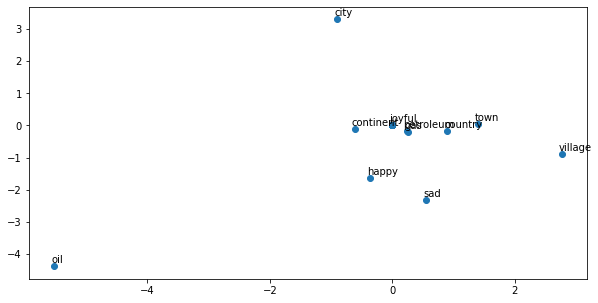

In [ ]:
selected_words = ['oil', 'gas', 'happy', 'sad', 'city', 'town', 'village', 'country', 'continent', 'petroleum', 'joyful']

selected_words_emb = np.vstack([emb_matrix[word_to_ids(word)] for word in selected_words])

result = compute_pca(selected_words_emb, 2)
plt.figure(figsize=[10,5])
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(selected_words):
    plt.annotate(word, xy=(result[i, 0] - 0.05, result[i, 1] + 0.1))
plt.show()

# Part 3: Classification using a simple bag of words (10% grade)

In [ ]:
# test:
tx='hello how are you ?'
len(sentence_to_ids('s'))
sentence_to_ids(tx)

[13075, 197, 32, 81, 188]

In [9]:
def sentence_to_emb(sentence: str):
    return_value = np.zeros((EMB_SIZE,))
    token_ids = sentence_to_ids(sentence) # returns an id for each token
    for token_id in token_ids: # produce an average embeding for the sentence
        return_value += emb_matrix[token_id]

    return_value = return_value / len(token_ids)
    return return_value

### Define our simple model

In [ ]:
model = nn.Sequential(
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, EMB_SIZE),
    nn.ReLU(),
    nn.Linear(EMB_SIZE, 2)
)

### Define our dataset and dataloader

In [ ]:
class Method1Dataset(Dataset):
    def __init__(self, datadict):
        self.data = [(sentence_to_emb(sentence), semantic)for sentence, semantic in datadict]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
all_dataset['train'][0]
len(all_dataset['train'])

8000

In [ ]:
train_dataset = Method1Dataset(all_dataset['train'])
eval_dataset = Method1Dataset(all_dataset['eval'])
test_dataset = Method1Dataset(all_dataset['test'])

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=TEST_EVAL_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_EVAL_BATCH_SIZE, shuffle=True)

### Define our training routine

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

In [ ]:
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        x, trg = batch
        optimizer.zero_grad()
        output = model(x.float())
        
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            x, trg = batch
            output = model(x.float())

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

### Train the model

In [ ]:
for epoch in range(10):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    valid_loss = evaluate(model, eval_dataloader, criterion)
    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01
	Train Loss: 0.626
	 Val. Loss: 0.534
Epoch: 02
	Train Loss: 0.502
	 Val. Loss: 0.513
Epoch: 03
	Train Loss: 0.487
	 Val. Loss: 0.497
Epoch: 04
	Train Loss: 0.478
	 Val. Loss: 0.486
Epoch: 05
	Train Loss: 0.469
	 Val. Loss: 0.487
Epoch: 06
	Train Loss: 0.462
	 Val. Loss: 0.490
Epoch: 07
	Train Loss: 0.452
	 Val. Loss: 0.486
Epoch: 08
	Train Loss: 0.443
	 Val. Loss: 0.483
Epoch: 09
	Train Loss: 0.428
	 Val. Loss: 0.477
Epoch: 10
	Train Loss: 0.414
	 Val. Loss: 0.487


### Check the results

In [ ]:
def get_all_targets_and_predicted(model, iterator):
    all_trg = []
    all_prd = []
    with torch.no_grad():
        for batch in iterator:
            x, trg = batch
            output = model(x.float())
            prd = output.argmax(1).tolist()
            
            all_trg += trg
            all_prd += prd
    return all_trg, all_prd

In [ ]:
print('__________________TRAIN DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, train_dataloader)
print(classification_report(trg, prd))
print('__________________EVAL DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, eval_dataloader)
print(classification_report(trg, prd))
print('__________________TEST DATASET__________________')
trg, prd = get_all_targets_and_predicted(model, test_dataloader)
print(classification_report(trg, prd))

__________________TRAIN DATASET__________________
              precision    recall  f1-score   support

           0       0.77      0.90      0.83      4000
           1       0.88      0.73      0.80      4000

    accuracy                           0.82      8000
   macro avg       0.83      0.82      0.81      8000
weighted avg       0.83      0.82      0.81      8000

__________________EVAL DATASET__________________
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      1000
           1       0.81      0.68      0.74      1000

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000

__________________TEST DATASET__________________
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       331
           1       0.83      0.64      0.72       331

    accuracy                      

# Part 4: Classification using an LSTM classifier

Use pytorch to implement an lstm model classifier. You can use any hyperparameters you want. You must report `classification_report` like previous example for all datasets. Remember your embeding layer initial value must be `emb_matrix`.

You must train the model two times.
First time freeze the embeding layer and second time fine-tune it end2end.
After that compare these two results and explatin the trade-off between freezing or fine-tuning the embedding layer.
You can read more about this in <a href="https://web.stanford.edu/class/cs224n/slides/cs224n-2019-lecture04-backprop.pdf">this link</a>.

Good Luck

In [8]:
del word_list, emb_list

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [12]:
def txt2ID(sentence , length=64):
  ids = sentence_to_ids(sentence)
  padding = [word_to_ids("<PAD>")[0] for _ in range(length - len(ids))]
  
  return ids + padding
# txt2ID('hello how are you', 10)

In [13]:
class Method2Dataset(Dataset):
    def __init__(self, data):
        self.data=data
        self.ID_txt = torch.tensor([txt2ID(data[i][0]) for i in range(len(data))])
        self.label = [data[i][1] for i in range(len(data))]
    def __len__(self):
        return len(self.data)
    def give_txt(self,idx):
        return self.data[idx][0]
    def __getitem__(self, idx):
        return (self.ID_txt[idx],self.label[idx])

In [14]:
# train_dataset = Method2Dataset(all_dataset['train'])
# train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=False)

# for i, batch in enumerate(train_dataloader):
#     x, trg = batch
#     break
#     # output = model(x)

In [15]:
# defining Datasets
train_dataset = Method2Dataset(all_dataset['train'])
eval_dataset = Method2Dataset(all_dataset['eval'])
test_ddataset = Method2Dataset(all_dataset['test'])
del all_dataset

In [16]:
# defining DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=TEST_EVAL_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_ddataset, batch_size=TEST_EVAL_BATCH_SIZE, shuffle=True)

In [19]:
del train_dataset, eval_dataset, test_ddataset

implementing the training procedure for one batch or one data gives a good insight.

In [200]:
# # For one data 
# num_embeddings, emb_size = emb_matrix.shape
# embedding = nn.Embedding(num_embeddings, emb_size)
# embedding.weight.data.copy_(torch.from_numpy(emb_matrix))
# lstm = nn.LSTM(emb_size, hidden_size=64, num_layers=1, batch_first=True)
# fc = nn.Linear(64, 2)
# x_in=train_dataset.__getitem__(1)[0]
# emb_in = embedding(x_in)
# x, (h_n, c_n) = lstm(emb_in)
# # x[-1]==h_n
# x = fc(x[-1])
# print(x.shape)

In [17]:
#____________YOUR CODE GOES HERE____________
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report

class LSTMClassifier(nn.Module):
    def __init__(self, emb_matrix, freeze_embedding):
        super().__init__()
        num_embeddings, emb_size = emb_matrix.shape
        self.embedding = nn.Embedding(num_embeddings, emb_size)
        self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))
        
        if freeze_embedding:
            self.embedding.weight.requires_grad = False
        
        self.lstm = nn.LSTM(emb_size, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.long()
        embeded = self.embedding(x)
        out, (h_n, c_n) = self.lstm(embeded)
        x = self.fc(out[:,-1,:])
        return x

In [18]:
model = LSTMClassifier(emb_matrix,freeze_embedding=True).to(device)

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [20]:
# # For one batch 
# num_embeddings, emb_size = emb_matrix.shape
# embedding = nn.Embedding(num_embeddings, emb_size)
# embedding.weight.data.copy_(torch.from_numpy(emb_matrix))
# lstm = nn.LSTM(emb_size, hidden_size=30, num_layers=1, batch_first=True)
# fc = nn.Linear(30, 1)
# print(data.size())
# embeded = embedding(data)
# print(embeded.size())
# x, (h_n, c_n) = lstm(embeded)
# print(x.size())
# print(h_n.size())
# x = fc(x[:,-1,:])
# print(x.size())

torch.Size([32, 64])
torch.Size([32, 64, 300])
torch.Size([32, 64, 30])
torch.Size([1, 32, 30])
torch.Size([32, 1])


In [23]:
######################   Training   ########################
from tqdm import tqdm
# train the model for a specified number of epochs
def trainer(model,num_epochs = 3):
    model=model.to(device)
    for epoch in range(num_epochs):
        # set the model to training mode
        model.train()

        # use tqdm to display a progress bar during training
        with tqdm(train_dataloader) as pbar:
            for text, label in pbar:
                label=label.to(device)
                text=text.to(device)
                # make predictions on the batch of data
                out_put = model(text)

                # calculate the loss
                loss = criterion(out_put.squeeze(), label.float())

                # reset the gradients
                optimizer.zero_grad()

                # backpropagate the loss
                loss.backward()

                # update the model's parameters
                optimizer.step()

                # update the progress bar
                pbar.set_description(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

        # set the model to evaluation mode
        model.eval()
        loss_val_sum=0
        # use the model to make predictions on the validation data
        with torch.no_grad():
            for text, label in eval_dataloader:
                label=label.to(device)
                text=text.to(device)
                predictions_val = model(text)
                # calculate the loss of the model on the validation data
                loss_val = criterion(predictions_val.squeeze(), label.float())
                loss_val_sum=loss_val_sum+loss_val
            print(f'TestLoss: {loss_val_sum/len(eval_dataloader):.4f}')
############################################################

In [27]:
trainer(model,5)

Epoch 1/5, Loss: 45.0546: 100%|██████████| 250/250 [00:04<00:00, 51.70it/s]


TestLoss: 54.9682


Epoch 2/5, Loss: 65.8490: 100%|██████████| 250/250 [00:04<00:00, 53.75it/s]


TestLoss: 54.9129


Epoch 3/5, Loss: 48.5204: 100%|██████████| 250/250 [00:05<00:00, 47.41it/s]


TestLoss: 54.9350


Epoch 4/5, Loss: 55.4518: 100%|██████████| 250/250 [00:06<00:00, 38.62it/s]


TestLoss: 54.9028


Epoch 5/5, Loss: 69.3125: 100%|██████████| 250/250 [00:03<00:00, 76.89it/s]


TestLoss: 54.9017


In [25]:
model2 = LSTMClassifier(emb_matrix,freeze_embedding=False).to(device)

In [28]:
trainer(model2,5)

Epoch 1/5, Loss: 62.3832: 100%|██████████| 250/250 [00:09<00:00, 25.47it/s]


TestLoss: 54.9457


Epoch 2/5, Loss: 58.9175: 100%|██████████| 250/250 [00:07<00:00, 35.42it/s]


TestLoss: 54.8797


Epoch 3/5, Loss: 58.9175: 100%|██████████| 250/250 [00:12<00:00, 19.81it/s]


TestLoss: 54.9457


Epoch 4/5, Loss: 72.7804: 100%|██████████| 250/250 [00:07<00:00, 33.45it/s]


TestLoss: 54.9677


Epoch 5/5, Loss: 51.9860: 100%|██████████| 250/250 [00:09<00:00, 25.75it/s]


TestLoss: 54.8797


# Conclusion: 
main differences between two models:

1. Learnability: A learnable embedding matrix can capture the meaning of the words more accurately by adapting to the specific characteristics of the training data, while a constant embedding matrix has fixed values that cannot be adapted to the training data.

2. Model capacity: A learnable embedding matrix adds additional parameters to the model, which increases the model's capacity and allows it to learn more complex relationships between the input and output. A constant embedding matrix has fewer parameters, which reduces the model's capacity and limits its ability to learn complex relationships.

3. Training time: A learnable embedding matrix requires more time to train, as the model has to optimize the values in the embedding matrix as well as the other parameters of the model. A constant embedding matrix requires less time to train, as the values in the embedding matrix are fixed and do not need to be optimized. This time difference can be clearly observed in the results of the training.

4. Model performance: In general, a learnable embedding matrix tends to outperform a constant embedding matrix in NLP text classification tasks, as it can capture the meanings of the words more accurately and learn more complex relationships between the input and output. However, the performance of a learnable embedding matrix may vary depending on the specific characteristics of the training data and the complexity of the task. However in our case due to computational cost restrictions the models are learned for 5 epoches and this point is not clear.

In summary, using a learnable embedding matrix or a constant embedding matrix in an LSTM model for NLP text classification can have different effects on the model's learnability, capacity, training time, and performance. You can choose the appropriate approach based on the specific requirements of your task and the resources available.